<a href="https://colab.research.google.com/github/nusaiba-afsheen/html-cv/blob/main/emotion_rec_affectnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tom99763/affectnethq
! unzip affectnethq

mkdir: cannot create directory ‘/root/.kaggle’: File exists
affectnethq.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  affectnethq.zip
replace anger/image0000006.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import tensorflow as tf
from tensorflow import keras

In [34]:
tf.get_logger().setLevel('ERROR')

In [5]:
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import matplotlib.pyplot as plt

In [26]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import RandomFlip, RandomRotation, RandomContrast, Rescaling, Resizing, Conv2D,MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.layers import RandomBrightness
# from tf.keras.utils import image_dataset_from_directory
# from tf.keras.applications import resnet50

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
img_paths=pd.read_csv("/content/labels.csv")

In [9]:
img_paths.drop(img_paths.index[(img_paths["label"]=="disgust")],axis=0,inplace=True)

In [10]:
img_paths.drop(img_paths.index[(img_paths["label"]=="contempt")],axis=0,inplace=True)
img_paths.drop(img_paths.index[(img_paths["label"]=="fear")],axis=0,inplace=True)

In [ ]:
img_paths.describe()

,pth,label
count,19885,19885
unique,19885,5
top,anger/image0000006.jpg,surprise
freq,1,4889


In [11]:
le=LabelEncoder()

In [12]:

img_paths["label"]=le.fit_transform(img_paths["label"])

In [13]:
img_paths.head()

,pth,label
0,anger/image0000006.jpg,4
1,anger/image0000007.jpg,0
2,anger/image0000012.jpg,0
4,anger/image0000060.jpg,0
5,anger/image0000061.jpg,0


In [14]:
just_paths=img_paths['pth'].values
labels = img_paths['label'].values
# /content/anger

In [ ]:
just_paths

array(['anger/image0000006.jpg', 'anger/image0000007.jpg',
       'anger/image0000012.jpg', ..., 'surprise/image0034966.jpg',
       'surprise/image0034973.jpg', 'surprise/image0034977.jpg'],
      dtype=object)

In [ ]:
labels

array([4, 0, 0, ..., 4, 2, 4])

In [39]:
train = tf.data.Dataset.from_tensor_slices((just_paths,labels))

In [40]:
dir="/content/"

def read_image(image_file,label):
  image = tf.io.read_file(dir+image_file)
  image = tf.image.decode_image(image,channels=3, dtype=tf.float32)
  image=tf.image.resize_with_pad(image,224,224)
  return image,label

In [53]:
def augment(image,label):
   image = tf.image.stateless_random_crop(image, size=[224,224, 3], seed=(0,2))
   image = tf.image.stateless_random_brightness( image, max_delta=0.5, seed=(0,2))
   image = tf.image.flip_left_right(image)
   return image,label

In [54]:
data=train.map(read_image).map(augment).batch(32)

In [ ]:
it = data.as_numpy_iterator()

In [ ]:
len(it.next())

2

In [ ]:
b=it.next()
b[0].shape

(32, 224, 224, 3)

In [ ]:
b[1]


array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0,
       0, 3, 0, 0, 4, 0, 0, 0, 0, 0])

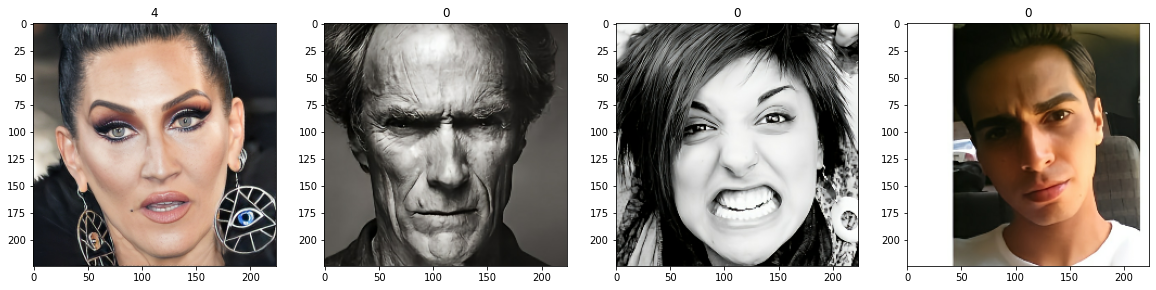

In [ ]:
fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate(b[0][:4]):
  ax[idx].imshow(img.astype(float))
  ax[idx].title.set_text(b[1][idx])

In [55]:
train_len = 10
val_len = 2
test_len = 2

train = data.take(train_len)
val = data.skip(train_len).take(val_len)
test = data.skip(train_len+val_len).take(test_len)

In [ ]:
  # # # #preprocessing
  # # Resizing(224,224,3),
  # # # Rescaling(1./255),

  # # #data augmentation
  # RandomFlip(mode='horizontal'),
  # RandomRotation(0.2),
  # RandomContrast(0.2),
  # # RandomBrightness(0.2),
  

  # #cnn
  # # Conv2D(16, 3, padding='same', activation='relu',input_shape=(224,224,1)),
  # # MaxPooling2D(),
  # # Conv2D(32, 3, padding='same', activation='relu',input_shape=(224,224,1)),
  # # MaxPooling2D(),

In [57]:
model = Sequential([
    
  #   # # #data augmentation
  # RandomFlip(mode='horizontal'),
  # RandomRotation(0.2),
  # RandomContrast(0.2),
  # # RandomBrightness(0.2),

  Conv2D(64, 3, padding='same', activation='relu',input_shape=(224,224,3)),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  Conv2D(128, 3, padding='same', activation='relu'),
  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  Conv2D(256, 3, padding='same', activation='relu'),
  # Conv2D(256, 3, padding='same', activation='relu'),
  Conv2D(256, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2,2),strides=(2,2)),
  Flatten(),
# Dense(512, activation='relu'),
  Dense(512, activation='relu'),
  Dropout(rate=0.5),
  Dense(5, activation='softmax')

])

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [59]:
history = model.fit(train , epochs=10, verbose=2, validation_data=val)

Epoch 1/10
10/10 - 332s - loss: 1.9560 - accuracy: 0.7250 - val_loss: 0.9313 - val_accuracy: 0.7500 - 332s/epoch - 33s/step
Epoch 2/10
10/10 - 325s - loss: 0.8147 - accuracy: 0.7969 - val_loss: 0.8547 - val_accuracy: 0.7500 - 325s/epoch - 32s/step
Epoch 3/10
10/10 - 330s - loss: 0.8021 - accuracy: 0.7969 - val_loss: 0.8551 - val_accuracy: 0.7500 - 330s/epoch - 33s/step
Epoch 4/10
10/10 - 324s - loss: 0.7957 - accuracy: 0.7969 - val_loss: 0.8553 - val_accuracy: 0.7500 - 324s/epoch - 32s/step
Epoch 5/10
10/10 - 330s - loss: 0.7613 - accuracy: 0.7969 - val_loss: 0.8417 - val_accuracy: 0.7500 - 330s/epoch - 33s/step
Epoch 6/10
10/10 - 324s - loss: 0.7541 - accuracy: 0.7969 - val_loss: 0.8405 - val_accuracy: 0.7500 - 324s/epoch - 32s/step
Epoch 7/10
10/10 - 330s - loss: 0.7584 - accuracy: 0.7969 - val_loss: 0.8394 - val_accuracy: 0.7500 - 330s/epoch - 33s/step
Epoch 8/10
10/10 - 329s - loss: 0.7272 - accuracy: 0.7969 - val_loss: 0.8288 - val_accuracy: 0.7500 - 329s/epoch - 33s/step
Epoch 9/